In [19]:
# model: Recurrent Neural Network
# data : IMDB large movie review dataset

import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

# plot_graphs: helper function, used to plot graphs
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("epoch")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()


In [12]:
# The dataset: IMDB large movie review dataset, we have used it before 
# last time we download the IMDS dataset:
'''
# 下载IMDB数据集
# 数据集已经预处理，单词序列被转化为整数序列，其中每个整数表示字典中的特定单词。

imdb = keras.datasets.imdb
# imdb.load(num_words) num_words参数保留了训练数据中最常见的10,000个单词。
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
'''
# in this time we use the TFDS to download

dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']


In [13]:
############## Dataset downloaded##############
# The dataset was preprocessed. The dataset info includes the encoder 
# (a tfds.features.text.SubwordTextEncoder)

encoder = info.features['text'].encoder
print("Vocabulary size: {}" .format(encoder.vocab_size))

Vocabulary size: 8185


In [14]:
# The encoder can convert a text String to Int String (encode) Or convert back (decode)
# Examples:

text_string = "I am bat man."
encoded_string = encoder.encode(text_string)
decoded_string = encoder.decode(encoded_string)
assert text_string == decoded_string
print("Encoded: "+ format(encoded_string)+ " Decoded: "+ format(decoded_string))
print()
for index in encoded_string:
  print(' {} ----> {}'. format(index, encoder.decode([index])))


Encoded: [12, 258, 2339, 7961, 223, 7975] Decoded: I am bat man.

 12 ----> I 
 258 ----> am 
 2339 ----> bat
 7961 ---->  
 223 ----> man
 7975 ----> .


In [15]:
# Prepare the data for training
# Next create batches of these encoded strings. use the padded_batch method
# to zero_pad the sequences to the length of the longest string in the batch.

BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_dataset.padded_batch(BATCH_SIZE)

##Create the model

#### A recurrent neural network processes sequence input by interating through the elements. RNN pass the outputs from one timestep to their input - and then to the next.

#### The tf.keras.layers.Bidirectional warpper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates (串联起来) the output. This helps the RNN to learn long range dependencies.


In [16]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(encoder.vocab_size, 64),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1)
])

from tensorflow import keras
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
 31/391 [=>............................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5020

KeyboardInterrupt: ignored

#Mask

#### 在刚刚训练的模型中，我们采用了pad填充0的方法，但是如果训练的数据里面填充了0，测试的数据里面没有，就会导致结果的偏移。

#### 解决方法是用Mask方法。教程中说结果影响不大。以下是pad和非pad的准确度影响：
[[-0.25375813]]
[[-0.48317122]]



In [ ]:
# If the prediction is >= 0.5, it is positive else it is negative.
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)


sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
# predictions without pad (pad = False)
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)


sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

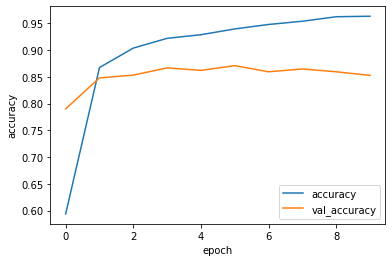

In [20]:
# show the accuracy
plot_graphs(history, 'accuracy')